In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import figure
from matplotlib.backends import backend_agg 
from scipy.stats import multivariate_normal
import torch
import itertools

In [2]:
import discrete_flows.disc_utils 
from discrete_flows.made import MADE
from discrete_flows.mlp import MLP
from discrete_flows.embed import EmbeddingLayer
from discrete_flows.disc_models import *

In [3]:
# will autoupdate any of the packages imported:
%load_ext autoreload
%autoreload 2

## Generating the training data. A 2D Mixture of 8 Gaussians. 

In [4]:
def sample_quantized_gaussian_mixture(batch_size):
    """Samples data from a 2D quantized mixture of Gaussians.
    This is a quantized version of the mixture of Gaussians experiment from the
    Unrolled GANS paper (Metz et al., 2017).
    Args:
        batch_size: The total number of observations.
    Returns:
        Tensor with shape `[batch_size, 2]`, where each entry is in
            `{0, 1, ..., max_quantized_value - 1}`, a rounded sample from a mixture
            of Gaussians.
    """
    clusters = np.array([[2., 0.], [np.sqrt(2), np.sqrt(2)],
                                             [0., 2.], [-np.sqrt(2), np.sqrt(2)],
                                             [-2., 0.], [-np.sqrt(2), -np.sqrt(2)],
                                             [0., -2.], [np.sqrt(2), -np.sqrt(2)]])
    assignments = torch.distributions.OneHotCategorical(
            logits=torch.zeros(8, dtype = torch.float32)).sample([batch_size])
    means = torch.matmul(assignments, torch.from_numpy(clusters).float())

    samples = torch.distributions.normal.Normal(loc=means, scale=0.1).sample()
    clipped_samples = torch.clamp(samples, -2.25, 2.25)
    quantized_samples = (torch.round(clipped_samples * 20) + 45).long()
    return quantized_samples

In [5]:
batch_size, sequence_length, vocab_size = 1024, 2, 91
data = sample_quantized_gaussian_mixture(batch_size)

Text(0.5, 1.0, 'Data Distribution')

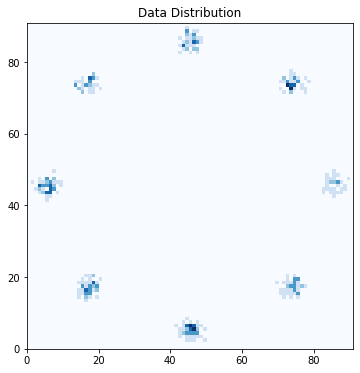

In [6]:
figsize = (6, 6)
fig = fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(1,1,1)
#canvas = backend_agg.FigureCanvasAgg(fig)
data_prob_table = np.histogramdd(data, bins=vocab_size)
ax.imshow(data_prob_table[0]/np.sum(data_prob_table[0]),
             cmap=cm.get_cmap("Blues", 6),
             origin="lower",
             extent=[0, vocab_size, 0, vocab_size],
             interpolation="nearest")
#fig.show()
ax.set_title("Data Distribution")

## Generating the model

In [7]:
num_flows = 1 # number of flow steps. This is different to the number of layers used inside each flow
temperature = 0.1 # used for the straight-through gradient estimator. Value taken from the paper
disc_layer_type = 'autoreg' #'autoreg' #'bipartite'

# This setting was previously used for the MLP and MADE networks. 
nh = 8 # number of hidden units per layer
vector_length = sequence_length*vocab_size

In [8]:
flows = []
for i in range(num_flows):
    if disc_layer_type == 'autoreg':
        
        #layer = EmbeddingLayer([batch_size, sequence_length, vocab_size], output_size=vocab_size)
        # MADE network is much more powerful. 
        layer = MADE([batch_size, sequence_length, vocab_size], vocab_size, [nh, nh, nh])
        
        disc_layer = DiscreteAutoregressiveFlow( layer, temperature, 
                                                    vocab_size )
    
    elif disc_layer_type == 'bipartite':
        # MLP will learn the factorized distribution and not perform well. 
        #layer = MLP(vector_length//2, vector_length//2, nh)
        
        layer = torch.nn.Embedding(vector_length//2, vector_length//2)
        
        disc_layer = DiscreteBipartiteFlow(layer, i%2, temperature, 
                                            vocab_size, vector_length, embedding=True)
        # i%2 flips the parity of the masking. It splits the vector in half and alternates
        # each flow between changing the first half or the second. 
    
    flows.append(disc_layer)
    
model = DiscreteAutoFlowModel(flows)
model

DiscreteAutoFlowModel(
  (flows): ModuleList(
    (0): DiscreteAutoregressiveFlow(
      (layer): MADE(
        (network): Sequential(
          (0): MaskedLinear(in_features=182, out_features=8, bias=True)
          (1): ReLU()
          (2): MaskedLinear(in_features=8, out_features=8, bias=True)
          (3): ReLU()
          (4): MaskedLinear(in_features=8, out_features=182, bias=True)
        )
      )
    )
  )
)

## Making random base probability distribution

/home/yaoqf/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


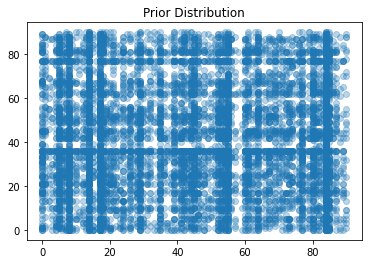

In [9]:
base_log_probs = torch.tensor(torch.randn(sequence_length, vocab_size), requires_grad = True)
base = torch.distributions.OneHotCategorical(logits = base_log_probs)

samps = base.sample((10000,)).argmax(-1)
plt.scatter(samps[:,0], samps[:,1], alpha=0.3)
plt.title("Prior Distribution")
plt.show()

## Fit model

epoch: 0 loss: 9.702465057373047
epoch: 150 loss: 7.706375598907471
epoch: 300 loss: 7.465000629425049
epoch: 450 loss: 7.428667068481445
epoch: 600 loss: 7.417491436004639
epoch: 750 loss: 7.330768585205078
epoch: 900 loss: 7.330483436584473
epoch: 1050 loss: 7.400208473205566
epoch: 1200 loss: 7.392160415649414
epoch: 1350 loss: 7.404997825622559


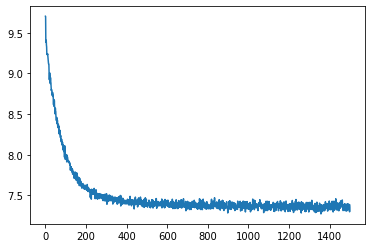

In [10]:
# A local minima (loss value around 7.3 is learning the factorized distribution). Global optima is somewhere around 6.7. May need to reset the model and base probability distribution in the above cells a few times to get a good result. 
epochs = 1500
learning_rate = 0.01
print_loss_every = epochs//10

losses = []
optimizer = torch.optim.Adam( 
        [
            {'params': model.parameters() , 'lr':learning_rate},
            {'params': base_log_probs, 'lr': learning_rate }
        ])

model.train()
for e in range(epochs):
    x = sample_quantized_gaussian_mixture(batch_size)
    x = F.one_hot(x, num_classes = vocab_size).float()
    
    if disc_layer_type == 'bipartite':
        x= x.view(x.shape[0], -1) #flattening vector
    
    optimizer.zero_grad()
    zs = model.forward(x)
    
    if disc_layer_type == 'bipartite':
        zs = zs.view(batch_size, sequence_length, -1) # adding back in sequence dimension
    
    base_log_probs_sm = torch.nn.functional.log_softmax(base_log_probs, dim=-1)
    #print(zs.shape, base_log_probs_sm.shape)
    logprob = zs*base_log_probs_sm # zs are onehot so zero out all other logprobs. 
    loss = -torch.sum(logprob)/batch_size
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.item())
    
    if e%print_loss_every==0:
        print('epoch:', e, 'loss:', loss.item())

plt.plot(losses)

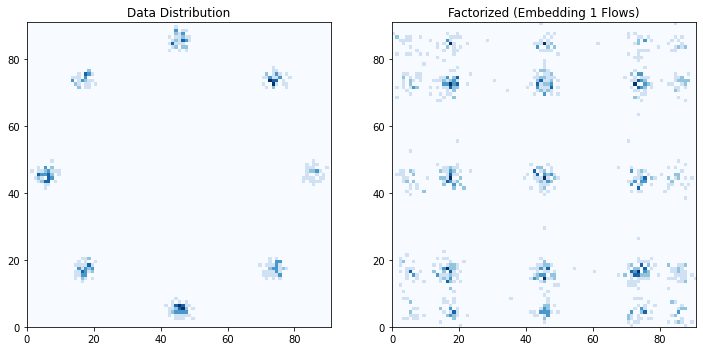

In [12]:
data_distribution = torch.distributions.OneHotCategorical(logits=base_log_probs)
samples = data_distribution.sample([batch_size])
if disc_layer_type == 'bipartite':
    samples = samples.view(samples.shape[0], -1)
samples = model.reverse(samples)
if disc_layer_type == 'bipartite':
    samples = samples.view(batch_size, sequence_length, -1)
data_samples = torch.argmax(samples, axis=-1).detach().numpy()
figsize = (12, 6)
fig = plt.figure(figsize=figsize)
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
data_prob_table = np.histogramdd(data, bins=vocab_size)
ax1.imshow(data_prob_table[0]/np.sum(data_prob_table[0]),
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
ax1.set_title("Data Distribution")
ax2.set_title("{} ({} {} Flows)".format(
  "factorized".replace("_", " ").title(),
  "embedding".title(),
  1))
learned_prob_table = np.histogramdd(data_samples, bins=vocab_size)
ax2.imshow(learned_prob_table[0]/np.sum(learned_prob_table[0]),
         cmap=cm.get_cmap("Blues", 6),
         origin="lower",
         extent=[0, vocab_size, 0, vocab_size],
         interpolation="nearest")
fig.show()
plt.gcf().savefig('figures/Fig2Reproduce.png', dpi=250)